## Non-Personalized Recommendations Utilizing both Ratings and Textual Reviews

This code applies a sentiment analysis model to predict a user's likeness of a book with no user-bias and low sample bias. This notebook makes use of the famous VADER sentiment analyzer. 

Code for Sentiment Analysis is adapted from this github repo: https://github.com/cjhutto/vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import swifter # to run pandas in multiple cpu cores 

### Read the dataset

In [2]:
goodreads_df = pd.read_csv('goodreads_reviews.csv')

In [ ]:
goodreads_df.shape # we have 1378033 reviews and 6 features

(1378033, 6)

In [ ]:
goodreads_df['user_id'].nunique() # number of users

18892

### Load the model

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [6]:
analyzer = SentimentIntensityAnalyzer() # calling the model class

The analyzier returns four different features representing the sample. The features are 'neg', 'neu', 'pos', and 'compound'. For our sentiment analysis task, we will use the compound feature because it was suggested by the authors.

### Find the sentiment for each sample

In [4]:
def sentiment_score(review: str):
    """Returns the sentiment score from the compund feature
    params"""
    return analyzer.polarity_scores(review)['compound']

In [7]:
sentiment_score(list(goodreads_df['review_text'])[0]) # finding the sentiment for one sample

0.5646

In [ ]:
goodreads_df['sentiment score'] = goodreads_df['review_text'].swifter.apply(sentiment_score) 

Pandas Apply:   0%|          | 0/1378033 [00:00<?, ?it/s]

#### Save the dataframe as a pickle object

In [ ]:
import pickle
with open('goodreads_sentiments', 'wb') as file:
    pickle.dump(goodreads_df, file)

In [3]:
# For loading the object
import pickle
with open('goodreads_sentiments', 'rb') as file:
    goodreads_df = pickle.load(file)

### Apply EDA
The purpose for that is to see relationships between the sentiment score and the ratings

In [3]:
print(f'The globl average rating is {goodreads_df['rating'].mean()} while the global average sentiment is {goodreads_df['sentiment score'].mean()}')

The globl average rating is 3.6850786592193367 while the global average sentiment is 0.5666029280866279


This is somewhat correct because most people have a rating of 3.68 (which is considered positive) while the average sentiment is positive

Let's make sure of this statstically by finding the correlation. First, we would need to scale values in [-1, 1] to [0, 5]

In [9]:
goodreads_df['scaled sentiment score'] = ((goodreads_df['sentiment score'] + 1) / 2) * 5

In [5]:
goodreads_df[['rating', 'scaled sentiment score']].corr()

,rating,scaled sentiment score
rating,1.000000,0.271737
scaled sentiment score,0.271737,1.000000


The correlation seems to be low between rating and sentiment score (weak positive correlation). It means higher rating tend to have a slightly higher sentiment score. This indicates that the sentiment score alone cannot be used for recomendation. However, it can make sense combining both in a hybrid recomendation system. We will proceed to try some approaches to come up with a conclusion at the end.

#### Plot distributions

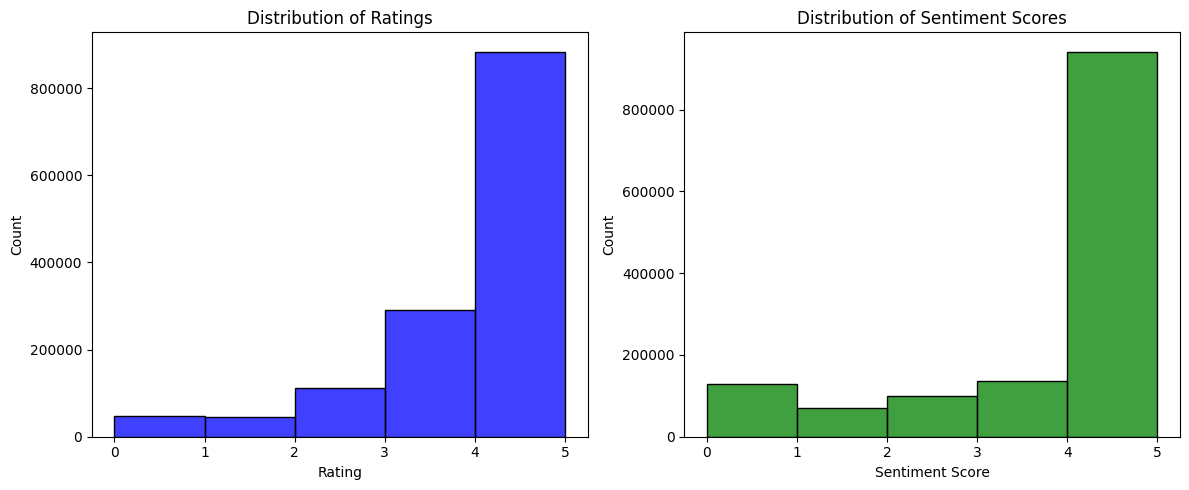

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Histogram for Ratings
plt.subplot(1, 2, 1)
sns.histplot(goodreads_df['rating'], bins=5,color="blue")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")

# Histogram for Sentiment Score
plt.subplot(1, 2, 2)
sns.histplot(goodreads_df['scaled sentiment score'], bins=5,color="green")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Scores")

plt.tight_layout()
plt.show()


### Recomendation

We will test 3 approaches:-

* Bayesian Scoring using Ratings 
* Bayesian Scoring using Sentiments
* Hybrid Recomendation System utilizing both Ratings and Sentiment Scoring

After that, we will proceed to test and compare the approaches to see which is better. It is interesting to see if sentiment will be of good use or not.

### Bayesian Scoring using Ratings

In [3]:
global_average_rating = goodreads_df['rating'].mean() # calculate global average rating
C = goodreads_df.shape[0]/goodreads_df['book_id'].nunique() # confidence factor: number of ratings divided by number of items

In [4]:
rating_bayesian_scoring = ((C*global_average_rating + goodreads_df.groupby('book_id')['rating'].sum())/
                          (C+goodreads_df.groupby('book_id')['rating'].count())).to_dict()

In [5]:
rating_bayesian_scoring = dict(sorted(rating_bayesian_scoring.items(), key=lambda item: item[1], reverse=True))

In [8]:
rating_bayesian_scoring_df = pd.DataFrame(rating_bayesian_scoring.items(), columns=['book', 'Bayesian Score'])

In [9]:
rating_bayesian_scoring_df.head(10) # get top 10 recomendations

,book,Bayesian Score
0,5,4.582458
1,136251,4.536908
2,32075671,4.530137
3,6,4.482937
4,3,4.476078
5,1,4.462032
6,8621462,4.451192
7,17332218,4.448717
8,6479550,4.443920
9,17131869,4.439753


### Bayesian Scoring using Sentiment

Scale the sentiment score from [-1, 1] to [0, 5]

In [ ]:
# goodreads_df['scaled sentiment score'] = ((goodreads_df['sentiment score']+1)/2)*5

Apply the recomendation

In [10]:
global_average_sentiment = goodreads_df['scaled sentiment score'].mean()

In [11]:
sentiment_bayesian_scoring = ((C*global_average_sentiment + goodreads_df.groupby('book_id')['scaled sentiment score'].sum())/
                          (C+goodreads_df.groupby('book_id')['scaled sentiment score'].count())).to_dict()

In [12]:
sentiment_bayesian_scoring = dict(sorted(sentiment_bayesian_scoring.items(), key=lambda item: item[1], reverse=True))

In [13]:
sentiment_bayesian_scoring_df = pd.DataFrame(sentiment_bayesian_scoring.items(), columns=['book', 'Bayesian Score'])

In [14]:
sentiment_bayesian_scoring_df.head(10)

,book,Bayesian Score
0,19547856,4.516690
1,22429350,4.516273
2,18189606,4.503671
3,10798416,4.498004
4,23705512,4.484340
5,33232571,4.483614
6,20170296,4.481045
7,21412202,4.480060
8,22926485,4.478569
9,8909152,4.477067


Before proceeding with other recomendation algorithms. Let's test both rating and sentiment bayesian scoring!

##### Spearman Correlation

In [15]:
bayesian_df = sentiment_bayesian_scoring_df.merge(rating_bayesian_scoring_df, on='book')

In [16]:
import scipy.stats as stats
correlation, _ = stats.spearmanr(bayesian_df['Bayesian Score_x'], bayesian_df['Bayesian Score_y'])

In [17]:
print(f"📊 Spearman Correlation: {correlation:.3f}")

📊 Spearman Correlation: 0.316


Since there is a weak positive correlation between bayesian rating and bayesian sentiemnt scoring, one could infer that sentiments provide additional information that is not seen by the numerical rating and vice versa. Perhaps sentiment scores likely highlight books with high emotional impact, even if their ratings aren’t the highest. Therefore, a hybrid approach between both systems might be the best way to use bayesian scoring.

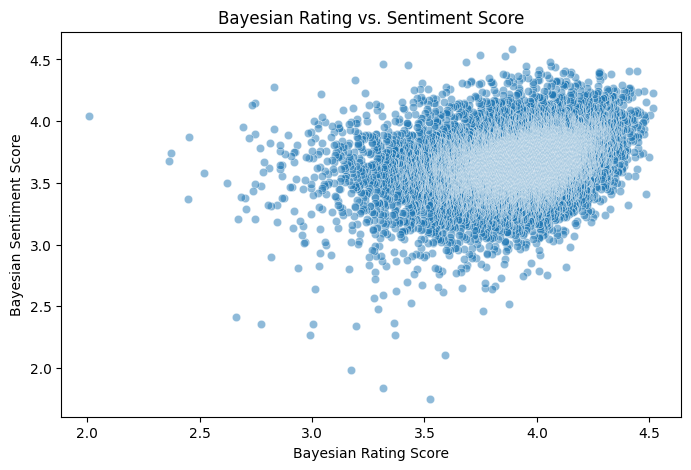

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(x=bayesian_df['Bayesian Score_x'], y=bayesian_df['Bayesian Score_y'], alpha=0.5)
plt.xlabel("Bayesian Rating Score")
plt.ylabel("Bayesian Sentiment Score")
plt.title("Bayesian Rating vs. Sentiment Score")
plt.show()

It seems that the recomendations that is made by the Bayesian ratings is similar to the ones made by the Sentiment-based Bayesian recommendation. Therefore, one can interpret that both models are simialr. Combining both of them in a hybrid system provides a system that helps with user-bias and is powerful. 

### Hybrid Recomendation using both bayesian scores

In [18]:
W1 = 0.5
W2 = 0.5

In [19]:
bayesian_df['hybrid'] = W1 * bayesian_df['Bayesian Score_x'] + W2 * bayesian_df['Bayesian Score_y']

In [21]:
bayesian_df

,book,Bayesian Score_x,Bayesian Score_y,hybrid
0,19547856,4.516690,4.230362,4.373526
1,22429350,4.516273,4.103548,4.309911
2,18189606,4.503671,4.046263,4.274967
3,10798416,4.498004,3.706303,4.102153
4,23705512,4.484340,4.151902,4.318121
...,...,...,...,...
25470,21853636,2.450318,3.874918,3.162618
25471,60748,2.445939,3.370919,2.908429
25472,6624871,2.370239,3.745318,3.057778
25473,2954411,2.362132,3.673450,3.017791


##### Spearman Correlation between Hybrid and Bayesian rating/Sentiments 

In [23]:
import scipy.stats as stats
correlation, _ = stats.spearmanr(bayesian_df['Bayesian Score_x'], bayesian_df['hybrid'])
print(f"📊 Spearman Correlation between bayesian ratings and hybrid: {correlation:.3f}")

📊 Spearman Correlation between bayesian ratings and hybrid: 0.814


In [24]:
import scipy.stats as stats
correlation, _ = stats.spearmanr(bayesian_df['Bayesian Score_y'], bayesian_df['hybrid'])
print(f"📊 Spearman Correlation between bayesian sentiments and hybrid: {correlation:.3f}")

📊 Spearman Correlation between bayesian sentiments and hybrid: 0.767


#### Extract book names from IDs

In [22]:
book_features = pd.read_csv('./book_features.csv')

In [25]:
book_features[['book_id', 'average_rating']].head()

,book_id,average_rating
0,5333265,4.00
1,1333909,3.23
2,7327624,4.03
3,6066819,3.49
4,287140,3.40


#### Set names for each book

In [37]:
bayesian_df.columns = ['book_id', 'Bayesian Score_x', 'Bayesian Score_y', 'hybrid']

In [41]:
trending_now_system = pd.merge(bayesian_df, book_features, on='book_id')[['book_id', 'title']]

### Employ Feedback Loop

In [10]:
goodreads_df

,user_id,book_id,rating,review_text,n_votes,n_comments,sentiment score,scaled sentiment score
0,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,28,1,0.5646,3.91150
1,8842281e1d1347389f2ab93d60773d4d,16981,3,Recommended by Don Katz. Avail for free in Dec...,1,0,0.6249,4.06225
2,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ...",22,0,0.8797,4.69925
3,8842281e1d1347389f2ab93d60773d4d,27161156,0,Recommended reading to understand what is goin...,5,1,0.8126,4.53150
4,8842281e1d1347389f2ab93d60773d4d,25884323,4,"I really enjoyed this book, and there is a lot...",9,1,0.9933,4.98325
...,...,...,...,...,...,...,...,...
1378028,35cef391b171b4fca45771e508028212,15745950,0,Can't wait for Travis' POV \n Travis Before Ab...,0,0,0.0000,2.50000
1378029,35cef391b171b4fca45771e508028212,10861195,0,Had this on my to-read shelf forever. Will upd...,0,0,0.0000,2.50000
1378030,35cef391b171b4fca45771e508028212,6131164,4,The last book left me wanting for more. I need...,0,0,0.7418,4.35450
1378031,35cef391b171b4fca45771e508028212,10025305,4,Things are heating up in the second novel of I...,0,0,0.9950,4.98750


## Implementing a Feedback loop

The below function handels the addition of a user review, which is crucial for a dynamic trending-now system. When a specific user adds a review, this dynamically handled.

In [ ]:
def add_review(user_id, book_id: int, rating: int, text: str):
    """Function that dynamically handles the addition of a user review"""
    # calculate the sentiment score
    sentiment = sentiment_score(text)
    # scale the sentiment score
    scaled_sentiment_score = ((sentiment + 1) / 2) * 5

    # make a row for a new entry
    new_entry = pd.DataFrame([{"user_id": user_id, "book_id": book_id, "rating": rating, "review_text": text,
                               "n_votes": 1, "n_comments": 1, "sentiment score": sentiment, "scaled sentiment score": scaled_sentiment_score}])
    # add new row to the df
    goodreads_df = pd.concat([goodreads_df, new_entry], ignore_index=True) 

    # since there is a new review, we need to recommend again

    # 1. calculate the "new" global avg ratings
    global_average_sentiment = goodreads_df['scaled sentiment score'].mean()
    global_average_rating = goodreads_df['rating'].mean()

    # 2. calculate the bayesian score for sentiments
    sentiment_bayesian_scoring = ((C*global_average_sentiment + goodreads_df.groupby('book_id')['scaled sentiment score'].sum())/
                          (C+goodreads_df.groupby('book_id')['scaled sentiment score'].count())).to_dict()
    sentiment_bayesian_scoring = dict(sorted(sentiment_bayesian_scoring.items(), key=lambda item: item[1], reverse=True))
    sentiment_bayesian_scoring_df = pd.DataFrame(sentiment_bayesian_scoring.items(), columns=['book', 'Bayesian Score'])

    # 3. Calculate the bayesian score for sentiments
    rating_bayesian_scoring = ((C*global_average_rating + goodreads_df.groupby('book_id')['rating'].sum())/
                          (C+goodreads_df.groupby('book_id')['rating'].count())).to_dict()
    rating_bayesian_scoring = dict(sorted(rating_bayesian_scoring.items(), key=lambda item: item[1], reverse=True))
    rating_bayesian_scoring_df = pd.DataFrame(rating_bayesian_scoring.items(), columns=['book', 'Bayesian Score'])

    # 4. combine them in a hybrid system
    bayesian_df = sentiment_bayesian_scoring_df.merge(rating_bayesian_scoring_df, on='book')
    bayesian_df['hybrid'] = W1 * bayesian_df['Bayesian Score_x'] + W2 * bayesian_df['Bayesian Score_y']

    # return the new hybrid system
    return bayesian_df
    

#### Save trending now system

In [43]:
import pickle
with open('trending_now_system', 'wb') as file:
    pickle.dump(trending_now_system, file)

In [46]:
list(trending_now_system['title'])

['Simon vs. the Homo Sapiens Agenda',
 'The Start of Me and You',
 "Since You've Been Gone",
 'The Statistical Probability of Love at First Sight',
 "You're Never Weird on the Internet",
 '2016 on Goodreads',
 'Neil Patrick Harris: Choose Your Own Autobiography',
 'As You Wish: Inconceivable Tales from the Making of The Princess Bride',
 'Sustained (The Legal Briefs, #2)',
 'Attachments',
 'Geekerella',
 'Unearthly (Unearthly, #1)',
 'The Unexpected Everything',
 'Nine Rules to Break When Romancing a Rake (Love By Numbers, #1)',
 'Lola and the Boy Next Door (Anna and the French Kiss, #2)',
 'My Lady Jane (The Lady Janies, #1)',
 'Emmy & Oliver',
 'First & Then',
 'Royally Matched (Royally, #2)',
 'Talking as Fast as I Can: From Gilmore Girls to Gilmore Girls, and Everything in Between',
 'The Rosie Project (Don Tillman, #1)',
 'Uprooted',
 'The Distance Between Us',
 'On the Fence',
 'Tangled (Tangled, #1)',
 'Radiance (Wraith Kings, #1)',
 'Illegal Contact (The Barons, #1)',
 'Queens 